## Generating Training and Test Data for the Mass-Spring-Damper Model 

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import cantera as ct
from scipy.integrate import solve_ivp

import pyDOE

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/MSD_100Cases/'

NTraining  = 100
NTest      = 10  
Nt         = 500
tout       = np.linspace(0.,15.,Nt)
SOLVER     = 'Radau'

MinVals    = [-4., -4.]
MaxVals    = [4., 4.]


try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

OutputDir += '/Orig/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

TestDir = OutputDir+'/test/'
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

TestDir = OutputDir+'/ext/'
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

OutputDir += '/train/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

OutputDir += '/ext/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

In [3]:
### Defining ODE and its Parameters

def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Jacobian(t, y):

    Eps = 1e-6
    J   = np.zeros([len(y), len(y)], dtype = np.float)

    for i in range(len(y)):
        y1 = y.copy()
        y2 = y.copy()

        y1[i] += Eps
        y2[i] -= Eps

        f1 = np.array(fOrig(t, y1))
        f2 = np.array(fOrig(t, y2))

        J[ : , i] = (f1 - f2) / (2. * Eps)

    return J

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

In [11]:
y0Mat

array([[0.775, 0.315],
       [0.895, 0.445],
       [0.835, 0.605],
       [0.945, 0.985],
       [0.445, 0.825],
       [0.145, 0.325],
       [0.015, 0.055],
       [0.795, 0.835],
       [0.585, 0.765],
       [0.005, 0.945],
       [0.565, 0.645],
       [0.185, 0.905],
       [0.755, 0.245],
       [0.605, 0.725],
       [0.575, 0.525],
       [0.725, 0.045],
       [0.505, 0.265],
       [0.665, 0.845],
       [0.555, 0.815],
       [0.855, 0.915],
       [0.455, 0.625],
       [0.415, 0.465],
       [0.785, 0.455],
       [0.955, 0.105],
       [0.885, 0.225],
       [0.335, 0.655],
       [0.805, 0.165],
       [0.215, 0.565],
       [0.155, 0.555],
       [0.845, 0.955],
       [0.425, 0.865],
       [0.815, 0.255],
       [0.975, 0.505],
       [0.085, 0.635],
       [0.685, 0.715],
       [0.235, 0.295],
       [0.435, 0.035],
       [0.545, 0.145],
       [0.595, 0.015],
       [0.635, 0.095],
       [0.875, 0.615],
       [0.275, 0.215],
       [0.135, 0.345],
       [0.3

In [4]:
# Sampling Initial Conditions

# y0Mat      = np.zeros((NTraining,2))
# y0Mat[:,0] = np.random.rand(NTraining)*4. - 2.0
# y0Mat[:,1] = np.random.rand(NTraining)*4. - 2.0
y0Mat     = pyDOE.lhs(2, samples=NTraining, criterion='center')
for i in range(2):
    y0Mat[:,i] = y0Mat[:,i] * (MaxVals[i] - MinVals[i]) + MinVals[i]
    
# y0MatTest      = np.zeros((NTest,2))
# y0MatTest[:,0] = np.random.rand(NTest)*4. - 2.0
# y0MatTest[:,1] = np.random.rand(NTest)*2. - 1.0
y0MatTest     = pyDOE.lhs(2, samples=NTest, criterion='center')
for i in range(2):
    y0MatTest[:,i] = y0MatTest[:,i] * (MaxVals[i] - MinVals[i]) + MinVals[i]

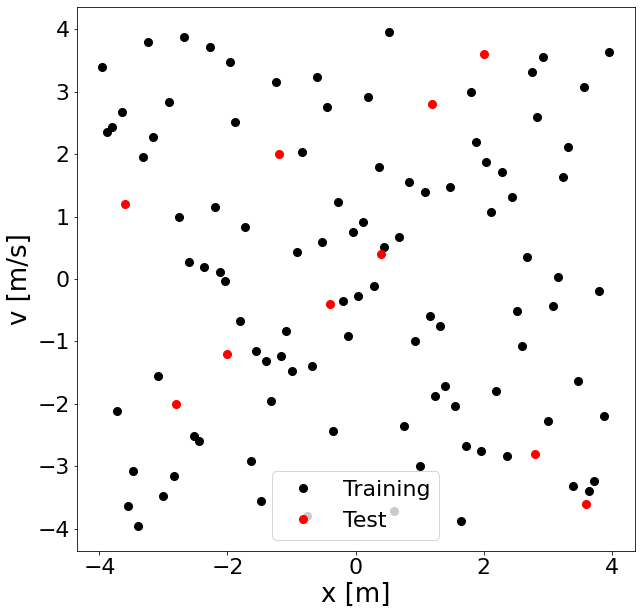

In [5]:
plt.figure(figsize=(10,10))
plt.plot(y0Mat[:,0],     y0Mat[:,1],     'ko', label='Training')
plt.plot(y0MatTest[:,0], y0MatTest[:,1], 'ro', label='Test')
plt.xlabel('x [m]')
plt.ylabel('v [m/s]')
plt.legend()

In [6]:
y0Mat

array([[-2.36,  0.2 ],
       [-0.76, -3.8 ],
       [-3.48, -3.08],
       [ 0.2 ,  2.92],
       [-1.  , -1.48],
       [ 3.64, -3.4 ],
       [-3.56, -3.64],
       [ 1.16, -0.6 ],
       [-0.6 ,  3.24],
       [ 1.64, -3.88],
       [ 2.92,  3.56],
       [ 3.96,  3.64],
       [-1.88,  2.52],
       [-3.96,  3.4 ],
       [-1.96,  3.48],
       [ 0.44,  0.52],
       [ 1.4 , -1.72],
       [ 0.28, -0.12],
       [-3.4 , -3.96],
       [ 3.4 , -3.32],
       [ 1.72, -2.68],
       [-1.16, -1.24],
       [-0.52,  0.6 ],
       [ 0.52,  3.96],
       [ 3.88, -2.2 ],
       [ 2.6 , -1.08],
       [-3.72, -2.12],
       [ 0.84,  1.56],
       [ 1.08,  1.4 ],
       [-2.84, -3.16],
       [ 2.04,  1.88],
       [ 3.56,  3.08],
       [-0.84,  2.04],
       [ 1.88,  2.2 ],
       [-0.28,  1.24],
       [-0.36, -2.44],
       [-2.2 ,  1.16],
       [ 0.68,  0.68],
       [-2.28,  3.72],
       [-0.12, -0.92],
       [ 2.68,  0.36],
       [-2.44, -2.6 ],
       [ 1.24, -1.88],
       [-0.

y0 =  [-2.36  0.2 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.76 -3.8 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.48 -3.08]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.2  2.92]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.   -1.48]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.64 -3.4 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.56 -3.64]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.16 -0.6 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.6   3.24]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.64 -3.88]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.92 3.56]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [3.96 3.64]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.88  2.52]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.96  3.4 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.96  3.48]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.44 0.52]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.4  -1.72]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.28 -0.12]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.4  -3.96]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.4  -3.32]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.72 -2.68]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.16 -1.24]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.52  0.6 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.52 3.96]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.88 -2.2 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.6  -1.08]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.72 -2.12]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.84 1.56]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.08 1.4 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.84 -3.16]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.04 1.88]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [3.56 3.08]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.84  2.04]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.88 2.2 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.28  1.24]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.36 -2.44]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.2   1.16]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.68 0.68]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.28  3.72]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.12 -0.92]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.68 0.36]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.44 -2.6 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.24 -1.88]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.68 -1.4 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [3.16 0.04]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.   -3.48]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.84 2.6 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.36 -2.84]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.68  3.88]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [3.24 1.64]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [3.32 2.12]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.52 -0.52]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.4  -1.32]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.04  0.76]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.44  2.76]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.04 -0.04]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.8  -0.68]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.   -2.28]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1. -3.]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.88  2.36]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.92 -1.  ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.96 -2.76]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.76 -2.36]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.2  -0.36]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.92  2.84]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.8   2.44]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.72 -3.24]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.52 -2.52]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.76  1.  ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.56 -1.16]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.92  0.44]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.56 -2.04]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.12 1.08]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.44 1.32]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.28 1.72]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.48 -3.56]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.8 -0.2]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.04 -0.28]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.24  3.8 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.76 3.32]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.6   0.28]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.32 -0.76]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.36 1.8 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.08 -1.56]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.32  1.96]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.48 -1.64]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.48 1.48]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.32 -1.96]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.12 0.92]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.64 -2.92]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.8 3. ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.12  0.12]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.16  2.28]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.64  2.68]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.6  -3.72]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.2 -1.8]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.72  0.84]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.08 -0.44]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.24  3.16]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.08 -0.84]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


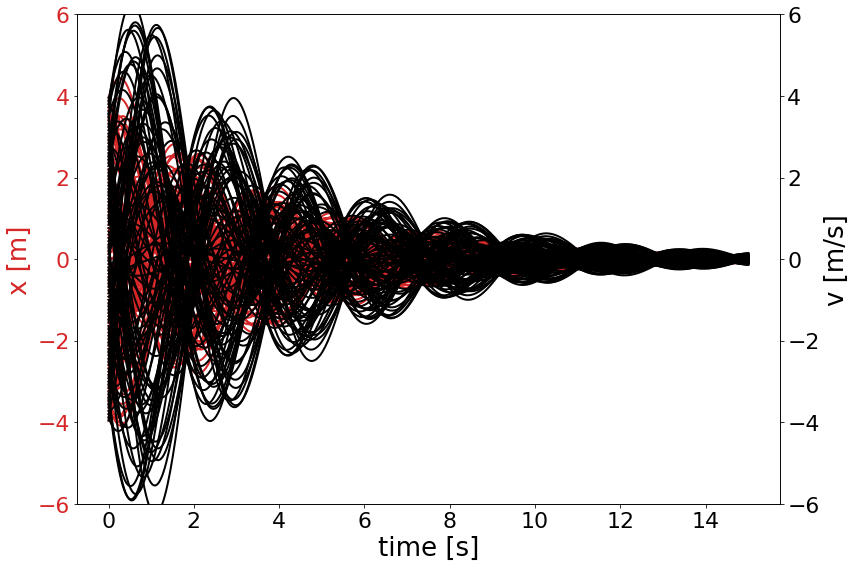

In [7]:
### Generating Training Data

fig, ax1 = plt.subplots(figsize=(12, 8))
ax2      = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for iSample in range(NTraining):
    y0         = y0Mat[iSample,:]
    print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    color = 'tab:red'
    ax1.plot(output.t, output.y[0,:], color=color)

    color = 'k'
    ax2.plot(output.t, output.y[1,:], color=color)
    
    
    ySourceTemp = np.zeros_like(output.y)
    JJTauMat    = np.zeros((output.y.shape[1], output.y.shape[0]*2))
    for it in range(Nt):
        ySourceTemp[:,it] = fOrig_Source(output.t, output.y[:,it])
        JJ                = fOrig_Jacobian(it, output.y[:,it])        
        JJEig, JJVec      = np.linalg.eig(JJ)
        JJTauMat[it,0:2]  = 1./JJEig.real
        JJTauMat[it,2:4]  = 1./JJEig.imag

    if (iSample == 0):
        tMat    = tMatTemp
        uMat    = uMatTemp
        yMat    = output.y.T 
        ySource = ySourceTemp.T
    else:
        tMat    = np.concatenate((tMat,    tMatTemp), axis=0)
        uMat    = np.concatenate((uMat,    uMatTemp), axis=0)
        yMat    = np.concatenate((yMat,    output.y.T), axis=0)
        ySource = np.concatenate((ySource, ySourceTemp.T), axis=0)

#     Header   = 't,x,v'
#     FileName = OutputDir+'/y.csv.'+str(iSample+1)
#     np.savetxt(FileName, np.concatenate((tMatTemp,output.y.T), axis=1), delimiter=',', header=Header, comments='')
        
        
color = 'tab:red'
ax1.set_xlabel('time [s]')
ax1.set_ylabel('x [m]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-6.,6.])

color = 'k'
ax2.set_ylabel('v [m/s]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([-6.,6.])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

y0 =  [1.2 2.8]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 3.6 -3.6]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.4 0.4]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 2.8 -2.8]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.2  2. ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.4 -0.4]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.  -1.2]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [2.  3.6]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-2.8 -2. ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-3.6  1.2]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


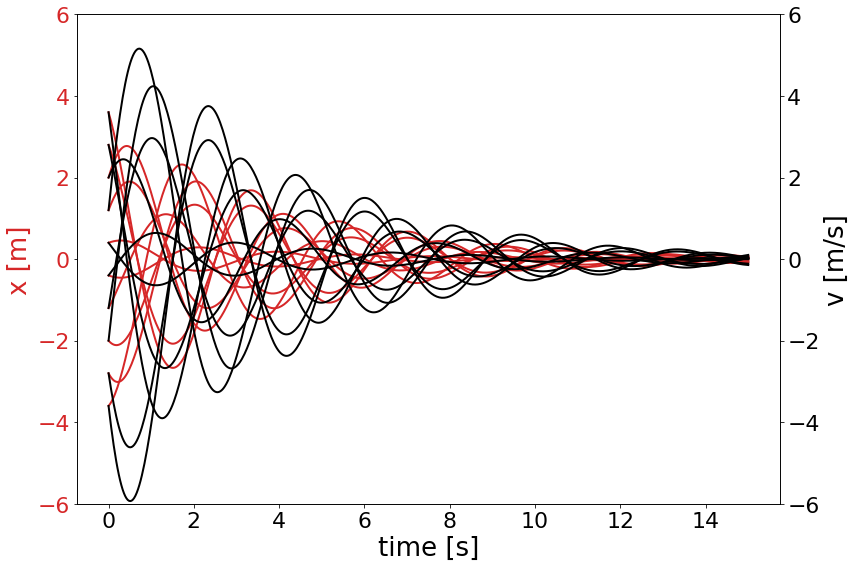

In [8]:
### Generating Test Data


fig, ax1 = plt.subplots(figsize=(12, 8))
ax2      = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for iSample in range(NTest):
    y0         = y0MatTest[iSample,:]
    print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    color = 'tab:red'
    ax1.plot(output.t, output.y[0,:], color=color)

    color = 'k'
    ax2.plot(output.t, output.y[1,:], color=color)
    
    ySourceTemp = np.zeros_like(output.y)
    for it in range(Nt):
        ySourceTemp[:,it] = fOrig_Source(output.t, output.y[:,it])

    if (iSample == 0):
        tMatTest    = tMatTemp
        uMatTest    = uMatTemp
        yMatTest    = output.y.T 
        ySourceTest = ySourceTemp.T
    else:
        tMatTest    = np.concatenate((tMatTest,    tMatTemp), axis=0)
        uMatTest    = np.concatenate((uMatTest,    uMatTemp), axis=0)
        yMatTest    = np.concatenate((yMatTest,    output.y.T), axis=0)
        ySourceTest = np.concatenate((ySourceTest, ySourceTemp.T), axis=0)
        
#     Header   = 't,x,v'
#     FileName = TestDir+'/y.csv.'+str(iSample+1)
#     np.savetxt(FileName, np.concatenate((tMatTemp,output.y.T), axis=1), delimiter=',', header=Header, comments='')
        
        
color = 'tab:red'
ax1.set_xlabel('time [s]')
ax1.set_ylabel('x [m]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-6.,6.])

color = 'k'
ax2.set_ylabel('v [m/s]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([-6.,6.])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
# ### Saving Data

# Header   = 't,x,v'
# FileName = OutputDir+'/Input.csv'
# np.savetxt(FileName, np.concatenate((tMat,uMat), axis=1), delimiter=',', header=Header, comments='')
        
# Header   = 't,x,v'
# FileName = OutputDir+'/Output.csv'
# np.savetxt(FileName, np.concatenate((tMat,yMat), axis=1), delimiter=',', header=Header, comments='')

# Header   = 't,dx,dv'
# FileName = OutputDir+'/dOutput.csv'
# np.savetxt(FileName, np.concatenate((tMat,ySource), axis=1), delimiter=',', header=Header, comments='')


# Header   = 'real_1,real_2,imag_1,imag_2'
# FileName = OutputDir + '/Jacobian.csv'
# np.savetxt(FileName, JJTauMat,    delimiter=',', header=Header, comments='')


# Header   = 't,x,v'
# FileName = TestDir+'/Input.csv'
# np.savetxt(FileName, np.concatenate((tMatTest,uMatTest), axis=1), delimiter=',', header=Header, comments='')
        
# Header   = 't,x,v'
# FileName = TestDir+'/Output.csv'
# np.savetxt(FileName, np.concatenate((tMatTest,yMatTest), axis=1), delimiter=',', header=Header, comments='')

# Header   = 't,dx,dv'
# FileName = TestDir+'/dOutput.csv'
# np.savetxt(FileName, np.concatenate((tMatTest,ySourceTest), axis=1), delimiter=',', header=Header, comments='')